In [1]:
import os
import cv2
import glob
import h5py
from scipy.io import loadmat
import numpy as np
from tqdm import tqdm
from utils import get_density_map_gaussian
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
%matplotlib inline


with_direction = False

C:\Users\Stanley Wu\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


(733, 2)


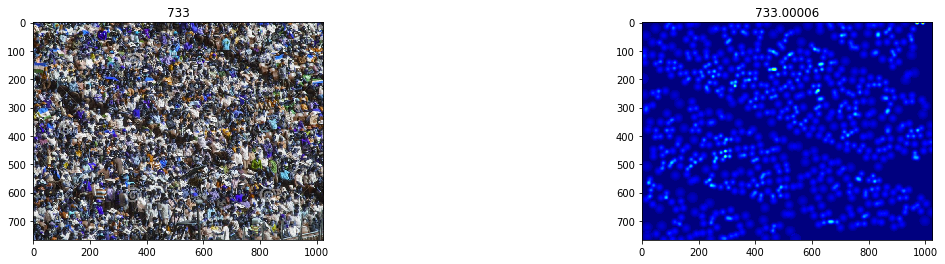

(90, 2)


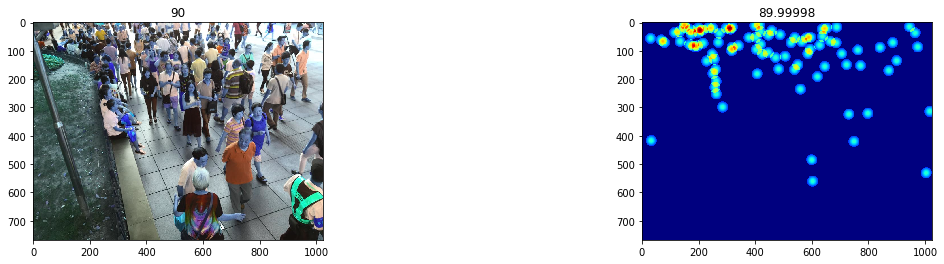

In [2]:
# Show a sample
img_paths = ['part_A/train_data/images/IMG_108.jpg',
             'part_B/train_data/images/IMG_20.jpg']
from utils import load_img
is_adaptive = False
for img_path in img_paths:
    is_adaptive = not is_adaptive
    img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
    img = cv2.imread(img_path)

    k = np.zeros((img.shape[0], img.shape[1]))

    gt = pts["image_info"][0, 0][0, 0][0]
    print(gt.shape)

    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1

    k = get_density_map_gaussian(k, gt, adaptive_mode=is_adaptive)

    fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 4))
    ax0.imshow(img)
    ax0.set_title(str(gt.shape[0]))
    ax1.imshow(k, cmap=plt.cm.jet)
    ax1.set_title(str(np.sum(k)))
    plt.show()

In [3]:
img_ori.shape

(768, 1024, 3)

In [4]:
img_ori.shape

(768, 1024, 3)

In [5]:
k.shape

(768, 1024)

In [2]:
from data import CrowdDataSet 
import matplotlib.pyplot as plt
import numpy as np
from data import CrowdDataSet 
from data import default_train_transforms, default_val_transforms
from torchvision import transforms
from PIL import Image
from utils import get_density_map_gaussian

In [3]:
ds = CrowdDataSet('part_A/train_data/')

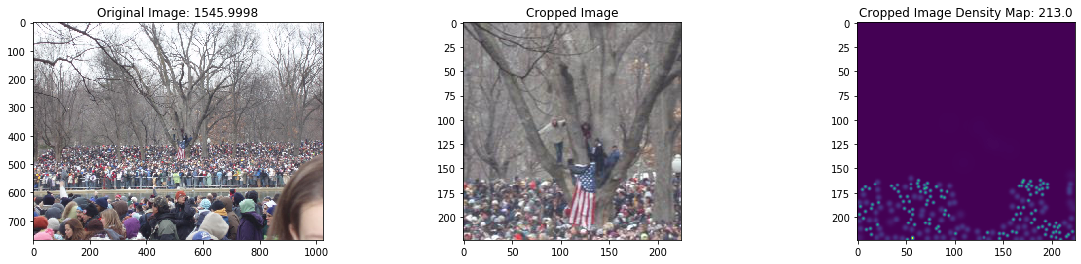

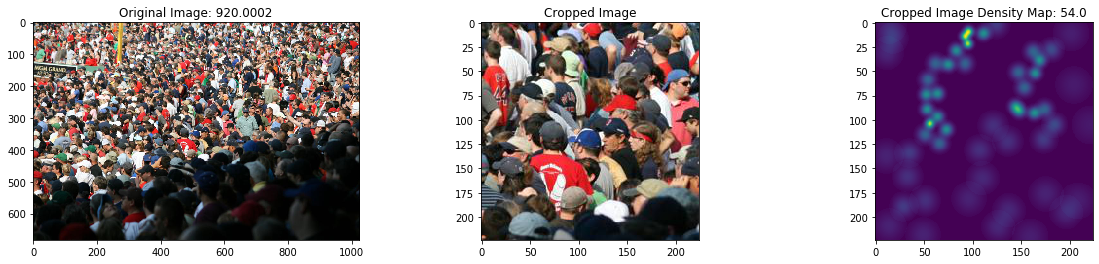

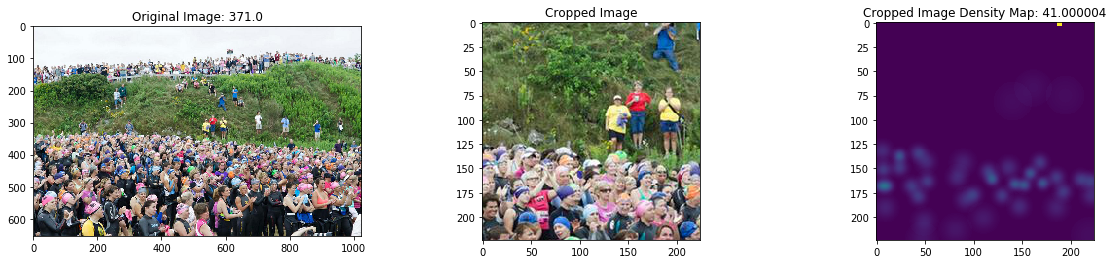

In [4]:
for i in range(3):
    fg, (p1, p2, p3) = plt.subplots(1, 3, figsize=(20, 4))

    x = ds[i]
    p1.imshow(x['image'])
    p1.set_title("Original Image: " + str(np.sum(x['den'])))

    loaders = {
        "train": CrowdDataSet(
            'part_A/train_data', default_train_transforms(output_size=224, factor=1)
        ),
        "val": CrowdDataSet(
            'part_A/test_data', default_val_transforms(output_size=224, factor=1)
        )
    }

    transformed_img = transforms.ToPILImage()(loaders['train'][i]['image']).convert('RGB')
    p2.imshow(transformed_img)
    p2.set_title("Cropped Image")

    k = np.zeros((transformed_img.width, transformed_img.height))
    k = get_density_map_gaussian(k, loaders['train'][i]['gt'], adaptive_mode=True)
    p3.imshow(k)
    p3.set_title('Cropped Image Density Map: ' + str(np.sum(k)))

In [5]:
from models import VGG16Transfer, ResNetTransfer, InceptionV3Transfer
from trainer import train, trainInception
import torch.optim as optim
import torch.nn as nn
import torch

# # Model
# model = VGG16Transfer(scale_factor=32) 
# # Loss
# criterion = nn.MSELoss()
# # Optimizer
# lr = 1e-5
# optimizer = optim.Adam(model.parameters(), lr=lr)


# # Train
# train(model, loaders['train'], criterion, optimizer, 20)
# torch.save(model, 'saved_models/vgg16')

print(len(loaders['train']))

300


In [7]:
import torch

model = torch.load('saved_models/vgg16')
model.eval()

train_vgg16_predictions = []
train_vgg16_actual = []

for i, data in enumerate(loaders['train'], 0):
    dt = data

    image = dt['image'].to()
    gt = dt['gt']
    
    model.eval()
    predictions = model(image[None, ...].float())
    predictions = predictions.squeeze().data.cpu().numpy() 
    count = np.sum(predictions) / 100
    
    k = np.zeros((image.shape[0], image.shape[1]))
    try:
        k = get_density_map_gaussian(k, gt, adaptive_mode=True)
    except:
        continue
        
    train_vgg16_predictions.append(count)
    train_vgg16_actual.append(np.sum(k))

C:\Users\Stanley Wu\Anaconda3\lib\site-packages\torch\nn\functional.py:3325: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Stanley Wu\Documents\DS4400\COVID-19-Crowd-Counting\utils.py:64: RuntimeWarning: invalid value encountered in true_divide
  density_map = density_map / (np.sum(density_map / num_gt))


In [8]:
test_vgg16_predictions = []
test_vgg16_actual = []
for i, data in enumerate(loaders['val'], 0):
    dt = data

    image = dt['image'].to()
    gt = dt['gt']
    
    model.eval()
    predictions = model(image[None, ...].float())
    predictions = predictions.squeeze().data.cpu().numpy() 
    count = np.sum(predictions) / 100
    
    k = np.zeros((image.shape[0], image.shape[1]))
    try:
        k = get_density_map_gaussian(k, gt, adaptive_mode=True)
    except:
        continue
        
    test_vgg16_predictions.append(count)
    test_vgg16_actual.append(np.sum(k))

In [9]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

for i, act in enumerate(train_vgg16_actual):
    if np.isnan(act):
        train_vgg16_actual[i] = 0
for i, act in enumerate(test_vgg16_actual):
    if np.isnan(act):
        test_vgg16_actual[i] = 0

train_r2 = r2_score([float(x) for x in train_vgg16_actual], [float(x) for x in train_vgg16_predictions])
test_r2 = r2_score([float(x) for x in test_vgg16_actual], [float(x) for x in test_vgg16_predictions])

print("VGG16")
print('Training r2: {}'.format(train_r2))
print('Testing r2: {}'.format(test_r2))

VGG16
Training r2: 0.7774186815469968
Testing r2: 0.4609205543107897


Text(0, 0.5, 'Predictions')

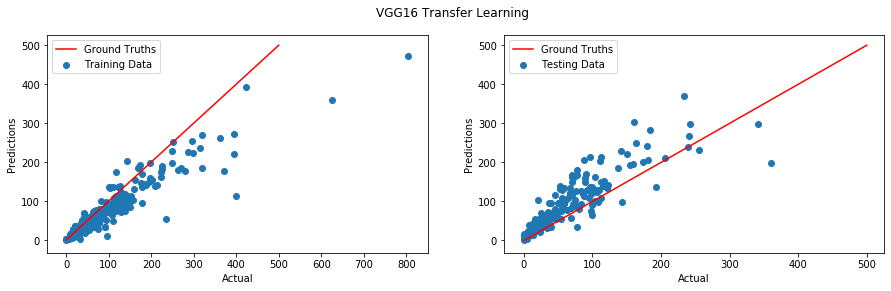

In [50]:
fg, (p1, p2) = plt.subplots(1, 2, figsize=(15, 4))

fg.suptitle('VGG16 Transfer Learning')

x = np.linspace(0,500,1000)
y = x
p1.plot(x, y, '-r', label='Ground Truths')
p1.scatter(train_vgg16_actual, train_vgg16_predictions, label='Training Data')
p1.legend()
p1.set_xlabel('Actual')
p1.set_ylabel('Predictions')

p2.plot(x, y, '-r', label='Ground Truths')
p2.scatter(test_vgg16_actual, test_vgg16_predictions, label='Testing Data')
p2.legend()
p2.set_xlabel('Actual')
p2.set_ylabel('Predictions')

In [11]:
model = torch.load('saved_models/resnet18')
model.eval()

train_resnet18_predictions = []
train_resnet18_actual = []

for i, data in enumerate(loaders['train'], 0):
    dt = data

    image = dt['image'].to()
    gt = dt['gt']
    
    model.eval()
    predictions = model(image[None, ...].float())
    predictions = predictions.squeeze().data.cpu().numpy() 
    count = np.sum(predictions) / 100
    
    k = np.zeros((image.shape[0], image.shape[1]))
    try:
        k = get_density_map_gaussian(k, gt, adaptive_mode=True)
    except:
        continue
        
    train_resnet18_predictions.append(count)
    train_resnet18_actual.append(np.sum(k))

C:\Users\Stanley Wu\Anaconda3\lib\site-packages\torch\nn\functional.py:3325: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Stanley Wu\Documents\DS4400\COVID-19-Crowd-Counting\utils.py:64: RuntimeWarning: invalid value encountered in true_divide
  density_map = density_map / (np.sum(density_map / num_gt))


In [12]:
test_resnet18_predictions = []
test_resnet18_actual = []
for i, data in enumerate(loaders['val'], 0):
    dt = data

    image = dt['image'].to()
    gt = dt['gt']
    
    model.eval()
    predictions = model(image[None, ...].float())
    predictions = predictions.squeeze().data.cpu().numpy() 
    count = np.sum(predictions) / 100
    
    k = np.zeros((image.shape[0], image.shape[1]))
    try:
        k = get_density_map_gaussian(k, gt, adaptive_mode=True)
    except:
        continue
        
    test_resnet18_predictions.append(count)
    test_resnet18_actual.append(np.sum(k))

In [21]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

for i, act in enumerate(train_resnet18_actual):
    if np.isnan(act):
        train_resnet18_actual[i] = 0
for i, act in enumerate(test_resnet18_actual):
    if np.isnan(act):
        test_resnet18_actual[i] = 0

train_r2 = r2_score([float(x) for x in train_resnet18_actual], [float(x) for x in train_resnet18_predictions])
test_r2 = r2_score([float(x) for x in test_resnet18_actual], [float(x) for x in test_resnet18_predictions])

print("ResNet18")
print('Training r2: {}'.format(train_r2))
print('Testing r2: {}'.format(test_r2))

ResNet18
Training r2: 0.31381846403461655
Testing r2: -1.267526559426991


Text(0, 0.5, 'Predictions')

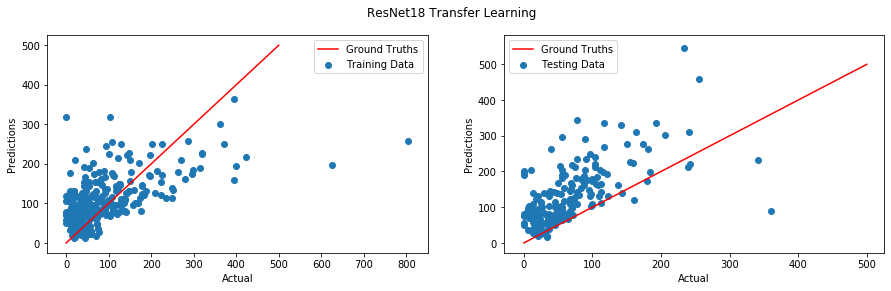

In [49]:
fg, (p1, p2) = plt.subplots(1, 2, figsize=(15, 4))

fg.suptitle('ResNet18 Transfer Learning')

x = np.linspace(0,500,1000)
y = x
p1.plot(x, y, '-r', label='Ground Truths')
p1.scatter(train_resnet18_actual, train_resnet18_predictions, label='Training Data')
p1.legend()
p1.set_xlabel('Actual')
p1.set_ylabel('Predictions')

p2.plot(x, y, '-r', label='Ground Truths')
p2.scatter(test_resnet18_actual, test_resnet18_predictions, label='Testing Data')
p2.legend()
p2.set_xlabel('Actual')
p2.set_ylabel('Predictions')